# Hindcast timeseries analysis

In [9]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cmocean
import pickle
import os
import statsmodels.api as sm
#import pyhht
import glob
import gsw
from scipy import signal, linalg, stats
from salishsea_tools import timeseries_tools, viz_tools, places
from matplotlib import gridspec, colors, animation
from datetime import datetime, timedelta
from dateutil.parser import parse
from copy import deepcopy
from IPython.display import HTML
from tqdm import tqdm_notebook as tqdm

%matplotlib inline
plt.rcParams['font.size'] = 12

## Define local functions

In [6]:
def reshape_to_grid(data, gridx, gridy, shape, xslice=None, yslice=None, subfac=None):
    """
    """
    
    gridded = np.zeros(shape)
    for y, x, val in zip(gridy, gridx, data):
        gridded[..., y, x] = val
    if xslice is not None:
        gridded = gridded[..., slice(*yslice), :]
    if yslice is not None:
        gridded = gridded[..., slice(*xslice)]
    if subfac is not None:
        gridded = gridded[..., ::subfac, ::subfac]

    return gridded

In [7]:
def calc_EOF(
    timeseries, gridx, gridy, shape,
    xslice=None, yslice=None, subfac=None,
    timecut=None, spacecut=None, calc_varimax=False,
    nmode=10,
):
    """
    """
    
    EOF = {}
    
    # Detrend timeseries (Butterworth filter)
    Z = deepcopy(timeseries)
    if timecut is not None:
        for i, col in enumerate(Z.T):  # --- Temporal trend
            Z[:, i] = col - signal.filtfilt(*signal.butter(2, timecut), col)
    if spacecut is not None:
        for i, row in enumerate(Z):  # ----- Spatial trend
            Z[i, :] = row - signal.filtfilt(*signal.butter(2, spacecut), row)
            #Z[i, :] = row - row.mean()
    
    # Calculate EOFs
    A_prime, sqrtL, E_T = np.linalg.svd(Z, full_matrices=False)
    EOF['A'] = A_prime.dot(np.diag(sqrtL))
    EOF['var'] = (EOF['A']**2).sum(axis=0) / (EOF['A']**2).sum()
    
    # Reshape modes
    EOF['E'] = []
    for mode in range(nmode):
        EOF['E'].append(reshape_to_grid(
            E_T.T[:, mode], gridx, gridy, shape,
            xslice=xslice, yslice=yslice, subfac=subfac,
        ))
    
    # Varimax rotation
    if calc_varimax:
        R = varimax(EOF['A'])
        EOF['B'] = EOF['A'].dot(R)
        EOF['Rvar'] = (EOF['B']**2).sum(axis=0) / (EOF['B']**2).sum()
        
        # Reshape modes
        EOF['U'] = []
        for mode in range(5):
            EOF['U'].append(reshape_to_grid(
                E_T.T.dot(R)[:, mode], gridx, gridy, shape,
                xslice=xslice, yslice=yslice, subfac=subfac,
            ))
    
    return EOF

In [7]:
def varimax(Phi, gamma=1.0, q=20, tol=1e-6):
    """From Wikipedia Varimax talk page
    https://en.wikipedia.org/wiki/Talk:Varimax_rotation
    """
    
    p, k = Phi.shape
    R = np.eye(k)
    d = 0
    for i in range(q):
        d_old = d
        Lambda = Phi.dot(R)
        u, s, vh = np.linalg.svd(Phi.T.dot(
            Lambda**3 - (gamma / p) *
            Lambda.dot(np.diag(np.diag(Lambda.T.dot(Lambda))))
        ))
        R = u.dot(vh)
        d = sum(s)
        if d_old != 0 and d/d_old < 1 + tol: break
    return R

## Extract hindcast slices
Extract and reshape indices

In [51]:
# Domain slice parameters
timerange = ['2016 Jan 1 00:00', '2016 Dec 31 23:59']
xslice, yslice = [100, 320], [380, 800]
zslice = 0
subfac = 5

# Create x and y indices
gridx, gridy = np.meshgrid(range(*xslice), range(*yslice))
gridx, gridy = gridx[::subfac, ::subfac], gridy[::subfac, ::subfac]

# Number of water points
nwater = np.prod(gridx.shape)

# Create reshaped tmask
mask = xr.open_dataset('/data/bmoorema/MEOPAR/grid/mesh_mask201702.nc')
tmask = mask.tmask.isel(t=0, z=zslice)
tmask[720:, :135] = 0  # mask out Discovery Passage nutrient plume
tmask = tmask.isel(y=slice(*yslice), x=slice(*xslice)).values.astype(bool)[::subfac, ::subfac].reshape(nwater)

# Reshape x and y indices
gridx = gridx.reshape(nwater)[tmask]
gridy = gridy.reshape(nwater)[tmask]

# Build time index
T = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSg3DTracerFields1hV18-06')
time = T.time.sel(time=slice(*timerange)).values.astype('datetime64[s]').astype(datetime)

OSError: [Errno -90] NetCDF: file not found: b'https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSg3DTracerFields1hV18-06'

Load wind

In [10]:
# Load v wind
GEM = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSaSurfaceAtmosphereFieldsV1')
j, i = places.PLACES['Sentry Shoal']['GEM2.5 grid ji']
v_wind = GEM.v_wind.sel(time=slice(*timerange)).isel(gridY=j, gridX=i)

Predefine filenames, timeseries array, quantity, vertical method, and dump params

In [11]:
# Predefine filenames, timeseries array, quantity, vertical method, and dump params
filenames = timeseries_tools.make_filename_list(timerange, 'T', ftype='ptrc', model='nowcast-green')
qty = 'silicon'
vmethod = 'slice'
fieldID = qty + timerange[0].split()[0] + vmethod + str(zslice)
dumpfile = os.path.join('/ocean/bmoorema/research/MEOPAR/analysis-ben/data', fieldID + '_dump')

**STOP!** This is the main extraction step and will take some time. Execute when ready ...

In [19]:
# Loop through filenames
timeseries = np.empty((0, tmask.sum()))
for filename in tqdm(filenames):
    
    # Load field from results file
    data = xr.open_dataset(filename).isel(y=slice(*yslice), x=slice(*xslice))[qty]
    
    # Either (1) extract horizontal slice at z index
    if vmethod is 'slice':
        
        # Extract slice and values
        data_reshape = data.isel(deptht=zslice).values
        
        # Reshape, subsample, and mask
        data_reshape = data_reshape[:, ::subfac, ::subfac].reshape(data.shape[0], nwater)[:, tmask]
    
    # Or (2) find depths of maximum values
    elif vmethod is 'max':
        data_reshape = np.take(
            data.deptht.values, data.values[:, :, ::subfac, ::subfac].argmax(axis=1),
        ).reshape(data.shape[0], nwater)[:, tmask]
    
    # Concatenate array onto timeseries array
    timeseries = np.concatenate((timeseries, data_reshape), axis=0)

# Dump timeseries results to pickle file
with open(dumpfile, 'wb') as output_file:
    pickle.dump({fieldID: timeseries}, output_file)

Loading silicon ... 100% (365 of 365) |####################################|Time: 0:20:21


If timeseries pickle files are already extracted, load them here.

In [11]:
# Load hindcast slices from pickle
timeseries = {}
for qty in ['vosaline', 'nitrate', 'silicon']:
    filename = f'/ocean/bmoorema/research/MEOPAR/analysis-ben/data/{qty}2016slice0_dump'
    with open(filename, 'rb') as fid:
        year = ''
        if qty is 'silicon':
            year = timerange[0].split()[0]
        timeseries[qty] = pickle.load(fid)[qty + year + 'slice0']

## Signal processing
Test various high pass filters for salinity

In [29]:
#mask.nav_lon[0, 0, gridy[100], gridx[100]]

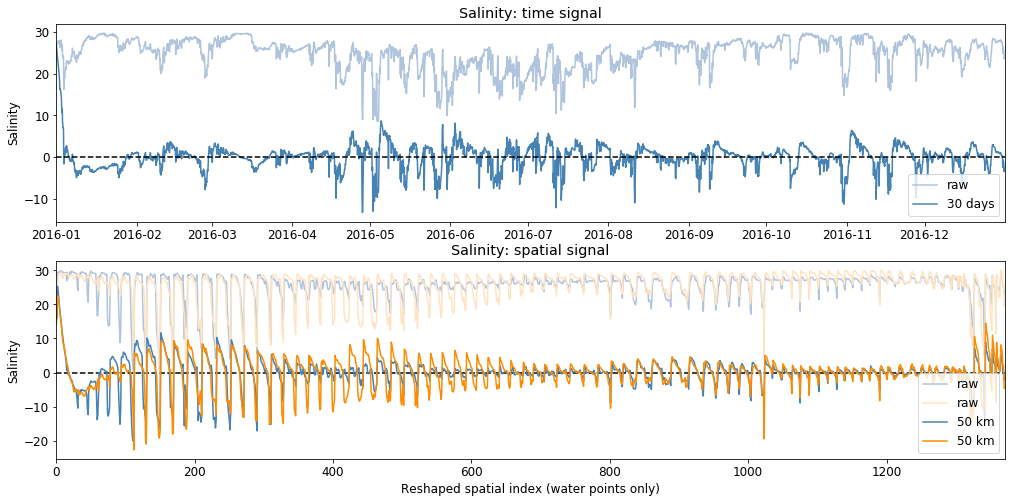

In [33]:
# Make figure
fig, axs = plt.subplots(2, 1, figsize=(17, 8))

# --- Top panel ---
axs[0].plot(time, timeseries['vosaline'][:, 100], label='raw', color='lightsteelblue')
axs[0].set_xlim(timerange)
axs[0].set_ylabel('Salinity')
axs[0].set_title('Salinity: time signal')
axs[1].set_xlabel('Reshaped spatial index (water points only)')

# Loop through lowcut
nyqst = 1 / 3600 / 2
lowcut = 1 / 86400 / 30
y = signal.lfilter(*signal.butter(2, lowcut / nyqst, btype='highpass'), timeseries['vosaline'][:, 100])
axs[0].plot(time, y, label='30 days', color='steelblue')
axs[0].plot([parse(t) for t in timerange], [0, 0], 'k--')

# Legend
axs[0].legend(loc=4)

# --- Bottom panels ---
nyqst = 1 / 500 / 2
lowcut = 1 / 50000
axs[1].set_ylabel('Salinity')
axs[1].set_title(f'Salinity: spatial signal')
axs[1].set_xlim([0, len(timeseries['vosaline'][0, :])])
axs[1].plot([0, 1400], [0, 0], 'k--')
axs[1].plot(timeseries['vosaline'][1800, :], color='lightsteelblue', label='raw')
axs[1].plot(timeseries['vosaline'][2500, :], color='bisque', label='raw')
y = signal.lfilter(*signal.butter(2, lowcut / nyqst, btype='highpass'), timeseries['vosaline'][1800, :])
axs[1].plot(y, color='steelblue', label='50 km')
y = signal.lfilter(*signal.butter(2, lowcut / nyqst, btype='highpass'), timeseries['vosaline'][2500, :])
axs[1].plot(y, color='darkorange', label='50 km')
axs[1].legend(loc=4)

fig.savefig('/ocean/bmoorema/research/documents/presentations/LaTeX/POseminar_27May2019/figures/salinity_signal.pdf', bbox_inches='tight')

Test various high pass filters for nitrate

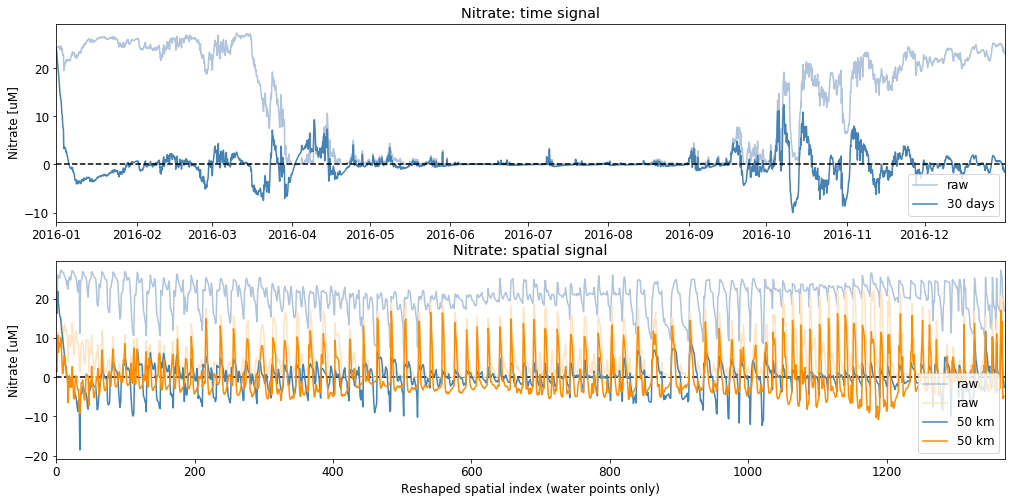

In [38]:
# Make figure
fig, axs = plt.subplots(2, 1, figsize=(17, 8))

# --- Top panel ---
axs[0].plot(time, timeseries['nitrate'][:, 100], label='raw', color='lightsteelblue')
axs[0].set_xlim(timerange)
axs[0].set_ylabel('Nitrate [uM]')
axs[0].set_title('Nitrate: time signal')
axs[1].set_xlabel('Reshaped spatial index (water points only)')

# Loop through lowcut
nyqst = 1 / 3600 / 2
lowcut = 1 / 86400 / 30
y = signal.lfilter(*signal.butter(2, lowcut / nyqst, btype='highpass'), timeseries['nitrate'][:, 100])
axs[0].plot(time, y, label='30 days', color='steelblue')
axs[0].plot([parse(t) for t in timerange], [0, 0], 'k--')

# Legend
axs[0].legend(loc=4)

# --- Bottom panels ---
nyqst = 1 / 500 / 2
lowcut = 1 / 50000
axs[1].set_ylabel('Nitrate [uM]')
axs[1].set_title(f'Nitrate: spatial signal')
axs[1].set_xlim([0, len(timeseries['nitrate'][0, :])])
axs[1].plot([0, 1400], [0, 0], 'k--')
axs[1].plot(timeseries['nitrate'][1800, :], color='lightsteelblue', label='raw')
axs[1].plot(timeseries['nitrate'][2500, :], color='bisque', label='raw')
y = signal.lfilter(*signal.butter(2, lowcut / nyqst, btype='highpass'), timeseries['nitrate'][1800, :])
axs[1].plot(y, color='steelblue', label='50 km')
y = signal.lfilter(*signal.butter(2, lowcut / nyqst, btype='highpass'), timeseries['nitrate'][2500, :])
axs[1].plot(y, color='darkorange', label='50 km')
axs[1].legend(loc=4)

fig.savefig('/ocean/bmoorema/research/documents/presentations/LaTeX/POseminar_27May2019/figures/nitrate_signal.pdf', bbox_inches='tight')

## EOF analysis
Calculate EOFs

In [12]:
# Loop through variables
EOF = {}
for qty in ['vosaline', 'nitrate', 'silicon']:

    # Lowpass filter params
    nyqst = 1 / 3600 / 2
    lowcut = 1 / 86400 / 30 # 30 days
    timecut = lowcut / nyqst
    nyqst = 1 / 500 / 2
    lowcut = 1 / 50000 # 50 km
    spacecut = lowcut / nyqst

    # Calculate EOFs
    EOF[qty] = calc_EOF(
        timeseries[qty], gridx, gridy, mask.nav_lon.shape,
        xslice=xslice, yslice=yslice, subfac=subfac,
        timecut=timecut, spacecut=spacecut, calc_varimax=False,
    )

### 10 km cutoff
Plot Hindcast PCs

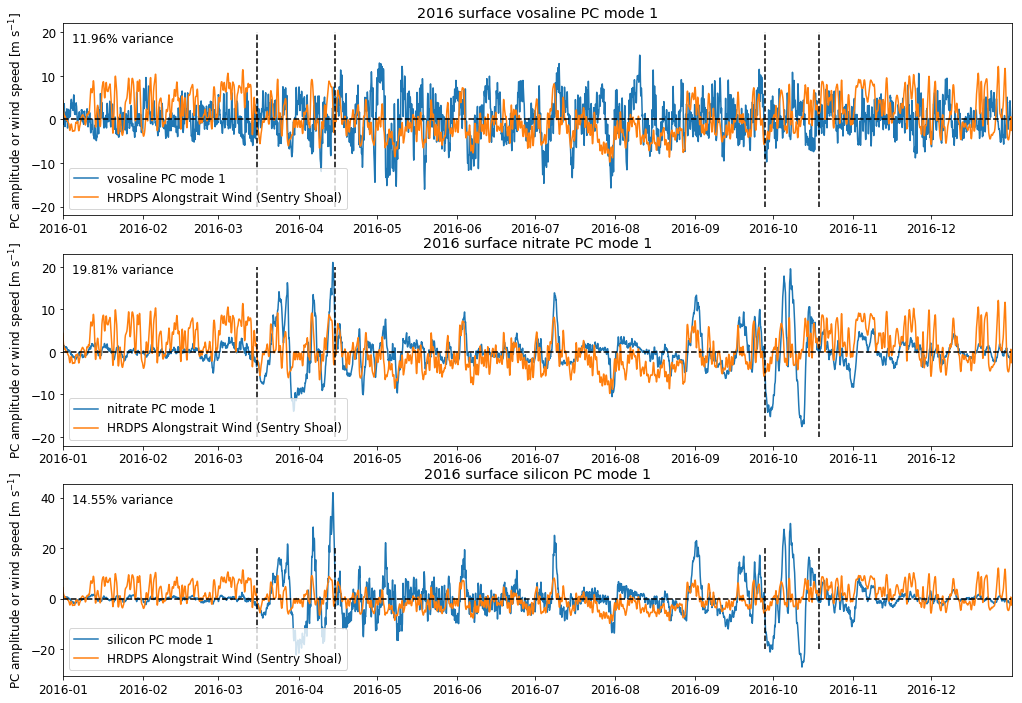

In [13]:
# Make figure
mode = 0
fig, axs = plt.subplots(3, 1, figsize=(17, 12))

for ax, qty in zip(axs, ['vosaline', 'nitrate', 'silicon']):

    ax.plot(time, -EOF[qty]['A'][:, mode]/5, label=f'{qty} PC mode {mode+1}')
    ax.plot(v_wind.time, signal.filtfilt(*signal.butter(2, 0.1), v_wind), label='HRDPS Alongstrait Wind (Sentry Shoal)')
    ax.plot([time[1800], time[1800]], [-20, 20], 'k--')
    ax.plot([time[2520], time[2520]], [-20, 20], 'k--')
    ax.plot([time[6500], time[6500]], [-20, 20], 'k--')
    ax.plot([time[7000], time[7000]], [-20, 20], 'k--')
    ax.plot([time[0], time[-1]], [0, 0], 'k--')
    ax.set_xlim(timerange)
    #ax.set_ylim([-20, 20])
    ax.set_ylabel('PC amplitude or wind speed [m s$^{-1}$]')
    PercentVar = EOF[qty]['var'][mode]*100
    ax.text(0.01, 0.9, f'{PercentVar:.2f}% variance', transform=ax.transAxes)
    #PercentVar = EOF[qty]['Rvar'][mode]*100
    #ax.text(0.01, 0.82, f'{PercentVar:.2f}% variance rotated', transform=ax.transAxes)
    ax.set_title(f'2016 surface {qty} PC mode {mode+1}')
    ax.legend(loc=3)

plt.show()

### Cross-correlation

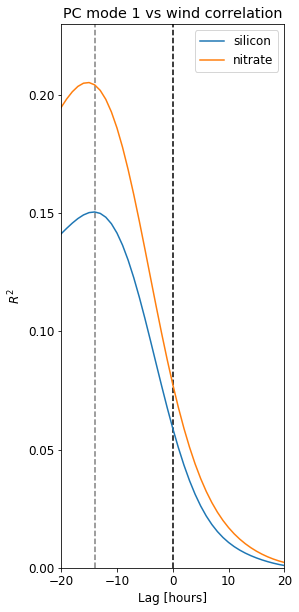

In [272]:
fig, ax = plt.subplots(1, 1, figsize=(4, 10))
ax.plot([-0, -0], [0, 0.3], 'k--')
ax.plot([-14, -14], [0, 0.3], 'k--', color='gray')
ax.set_xlim([-20, 20])
ax.set_ylim([0, 0.23])
ax.set_xlabel('Lag [hours]')
ax.set_ylabel('$R^{2}$')
ax.set_title('PC mode 1 vs wind correlation')

indices = np.arange(-30, 31)

for qty in ['silicon', 'nitrate']:
    rsq = np.empty(len(indices))
    for k, i in enumerate(indices):
        x = signal.filtfilt(*signal.butter(2, 0.1), v_wind)
        y = signal.filtfilt(*signal.butter(2, 0.1), EOF[qty]['A'][:, 0])
        rsq[k] = sm.OLS(np.roll(y, i), sm.add_constant(x)).fit().rsquared

    ax.plot(indices, rsq, label=qty)
    
ax.legend()
fig.savefig('/ocean/bmoorema/research/documents/presentations/LaTeX/SSEC2018/figures/PCA_lag.pdf', dpi=300, bbox_inches='tight')
plt.show()

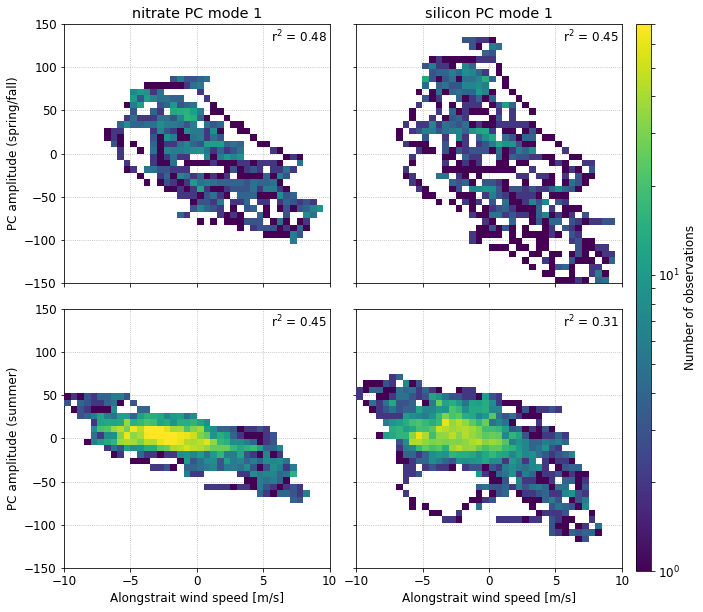

In [257]:
# Make figure
mode = 0
indices = [
    #list(range(1800)) + list(range(7000, 8784)),
    list(range(1800, 2520)) + list(range(6500, 7000)),
    list(range(2520, 6500)),
]
qtys = ['nitrate', 'silicon']

fig, axs = plt.subplots(2, 2, figsize=(10, 10), gridspec_kw={'hspace': 0.1, 'wspace': 0.1})
for col, qty in enumerate(qtys):
    axs[0, col].set_title(f'{qty} PC mode 1')
    axs[1, col].set_xlabel('Alongstrait wind speed [m/s]')
    axs[0, col].xaxis.set_ticklabels('')
    #axs[1, col].xaxis.set_ticklabels('')

for row, index, season in zip(axs, indices, ['spring/fall', 'summer']):
    row[0].set_ylabel(f'PC amplitude ({season})')
    row[1].yaxis.set_ticklabels('')
    #row[2].yaxis.set_ticklabels('')
    for ax, qty in zip(row, qtys):
        x = signal.filtfilt(*signal.butter(2, 0.1), v_wind)[index]
        y = signal.filtfilt(*signal.butter(2, 0.1), EOF[qty]['A'][:, 0])[index]
        fit = sm.OLS(np.roll(y, -14), sm.add_constant(x)).fit()
        c = ax.hist2d(
            x, np.roll(y, -14), norm=colors.LogNorm(), bins=40, vmin=1, vmax=70, range=np.array([(-10, 10), (-150, 150)]), zorder=10,
        )
        ax.text(0.78, 0.93, f'r$^2$ = {fit.rsquared:.2f}', transform=ax.transAxes)
        ax.grid(linestyle=':', zorder=0)
        ax.xaxis.set_ticks(range(-10, 11, 5))

cax = fig.add_axes([0.92, 0.12, 0.02, 0.76])
plt.colorbar(c[3], cax=cax, label='Number of observations')

fig.savefig('/ocean/bmoorema/research/documents/presentations/LaTeX/SSEC2018/figures/PCA_corr.pdf', dpi=300, bbox_inches='tight')
plt.show()

### Spectral Analysis

/home/bmoorema/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in true_divide


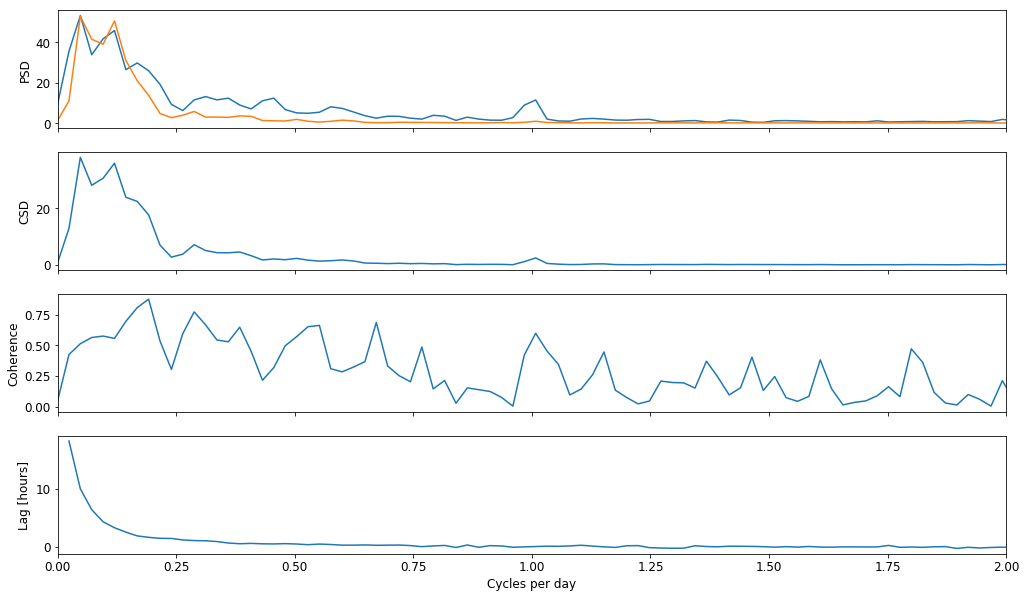

In [19]:
fW, PW = signal.welch(v_wind, 24, nperseg=1e3, noverlap=10)
fN, PN = signal.welch(EOF['nitrate']['A'][:, 0]/8, 24, nperseg=1e3, noverlap=10)
fCd, CSD = signal.csd(v_wind, EOF['nitrate']['A'][:, 0]/8, 24, nperseg=1e3, noverlap=10)
fCh, COH = signal.coherence(v_wind, EOF['nitrate']['A'][:, 0]/8, 24, nperseg=1e3, noverlap=10)
ph = np.angle(CSD) / (2 * np.pi * fCd)

fig, axs = plt.subplots(4, 1, figsize=(17, 10))

for ax in axs:
    ax.set_xlim([0, 2])

axs[0].plot(fW, PW)
axs[0].plot(fN, PN)
axs[0].set_ylabel('PSD')
axs[0].xaxis.set_ticklabels('')

axs[1].plot(fCd, np.abs(CSD))
axs[1].set_ylabel('CSD')
axs[1].xaxis.set_ticklabels('')

axs[2].plot(fCh, COH)
axs[2].set_ylabel('Coherence')
axs[2].xaxis.set_ticklabels('')

axs[3].plot(fCd, ph)
axs[3].set_ylabel('Lag [hours]')
axs[3].set_xlabel('Cycles per day')

plt.show()

Plot Hindcast EOFs

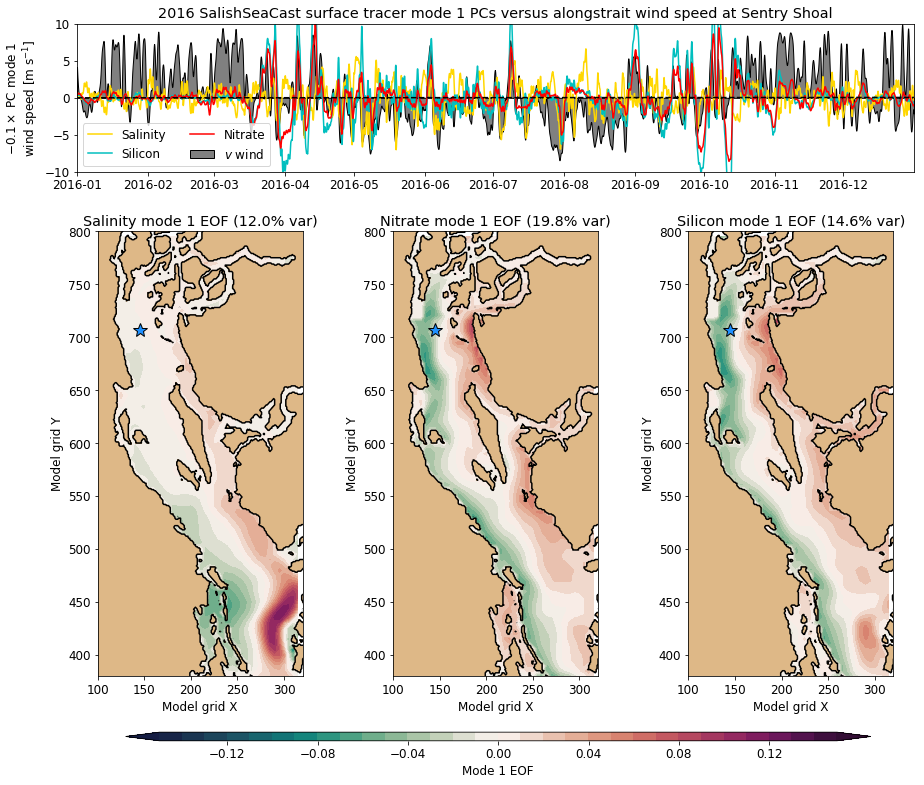

In [130]:
# Make figure
mode = 0
fig = plt.figure(figsize=(15, 12))
gs = gridspec.GridSpec(2, 3, height_ratios=[1, 3])
axs = [fig.add_subplot(gs[0, :])]
axs.extend([fig.add_subplot(gs[1, col]) for col in range(3)])

axs[0].fill_between(
    v_wind.time.values.astype('datetime64[s]').astype(datetime),
    signal.filtfilt(*signal.butter(2, 0.05), v_wind), 0, edgecolor='k', facecolor='gray', label='$v$ wind',
)
for qty, color, label in zip(['vosaline', 'silicon', 'nitrate'], ['gold', 'c', 'red'], ['Salinity', 'Silicon', 'Nitrate']):
    axs[0].plot(time, signal.filtfilt(*signal.butter(2, 0.1), -EOF[qty]['A'][:, mode]/10), label=label, color=color)
axs[0].plot([time[0], time[-1]], [0, 0.05], 'k--')
axs[0].set_xlim(timerange)
axs[0].set_ylim([-10, 10])
axs[0].set_ylabel('$-0.1 \\times$ PC mode 1\nwind speed [m s$^{-1}$]')
axs[0].set_title('2016 SalishSeaCast surface tracer mode 1 PCs versus alongstrait wind speed at Sentry Shoal')
axs[0].legend(loc=3, ncol=2)
for ax, qty, label in zip(axs[1:], ['vosaline', 'nitrate', 'silicon'], ['Salinity', 'Nitrate', 'Silicon']):
    
    # Percent var
    PercentVar = EOF[qty]['var'][mode]*100
    
    # Formatting
    ax.set_xlim(xslice)
    ax.set_ylim(yslice)
    ax.set_xlabel('Model grid X')
    ax.set_ylabel('Model grid Y')
    ax.set_title(f'{label} mode 1 EOF ({PercentVar:.1f}% var)')
    viz_tools.set_aspect(ax)

    # Plot EOF
    c = ax.contourf(
        range(*xslice, 5), range(*yslice, 5), EOF[qty]['E'][mode], 
        levels=np.arange(-0.15, 0.151, 0.01),
        cmap=cmocean.cm.curl, extend='both',
    )
    
    # Plot landmask
    ax.contourf(mask.tmask.isel(t=0, z=0), levels=[-0.01, 0.01], colors='burlywood')
    ax.contour(mask.tmask.isel(t=0, z=0), levels=[-0.01, 0.01], colors='k')
    
    # Plot sentry shoal
    j, i = places.PLACES['Sentry Shoal']['NEMO grid ji']
    ax.plot(i, j, 'k*', markerfacecolor='dodgerblue', markersize=14)
    
# Colorbar
cax = fig.add_axes([0.17, 0.05, 0.69, 0.01])
fig.colorbar(c, cax=cax, orientation='horizontal', label=f'Mode {mode+1} EOF')

# Output
fig.savefig('/ocean/bmoorema/research/documents/presentations/LaTeX/SSEC2018/figures/PCA.pdf', dpi=300, bbox_inches='tight')
plt.show()